In [1]:
import itertools
from pathlib import Path
from pprint import pprint

from matplotlib import pyplot as plt, cm
import numpy as np
import pandas as pd
from pandas_path import path
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from tqdm import tqdm

pd.set_option('max_colwidth', 80)

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from keras import backend as K

RANDOM_SEED = 42

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

2022-04-18 13:29:54.212253: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-18 13:29:54.535320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 13:29:55.004367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 13:29:55.005493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
DATA_PATH = Path.cwd() / 'data/'

metadata = pd.read_csv(DATA_PATH / 'metadata.csv', index_col='sample_id')
metadata.head()

,split,instrument_type,features_path,features_md5_hash
sample_id,,,,
S0000,train,commercial,train_features/S0000.csv,017b9a71a702e81a828e6242aa15f049
S0001,train,commercial,train_features/S0001.csv,0d09840214054d254bd49436c6a6f315
S0002,train,commercial,train_features/S0002.csv,3f58b3c9b001bfed6ed4e4f757083e09
S0003,train,commercial,train_features/S0003.csv,e9a12f96114a2fda60b36f4c0f513fb1
S0004,train,commercial,train_features/S0004.csv,b67603d3931897bfa796ac42cc16de78


In [4]:
train_files = metadata[metadata['split'] == 'train']['features_path'].to_dict()
val_files = metadata[metadata['split'] == 'val']['features_path'].to_dict()
test_files = metadata[metadata['split'] == 'test']['features_path'].to_dict()

print(f'Number of training samples: {len(train_files)}')
print(f'Number of validation samples: {len(val_files)}')
print(f'Number of testing samples: {len(test_files)}')

Number of training samples: 766
Number of validation samples: 293
Number of testing samples: 511


# Exploratory Data Analysis

[Text(0, 0, '64'), Text(0, 0, '12'), Text(0, 0, '0')]

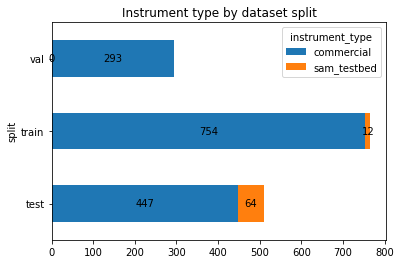

In [5]:
# Share of sample from commercial instruments vs. SAM testbed
meta_instrument = (
    metadata.reset_index()
    .groupby(['split', 'instrument_type'])['sample_id']
    .aggregate('count')
    .reset_index()
)

meta_instrument = meta_instrument.pivot(
    index='split', columns='instrument_type', values='sample_id'
).reset_index()

meta_instrument.head()

ax = meta_instrument.plot(
    x='split',
    kind='barh',
    stacked=True,
    title='Instrument type by dataset split',
    mark_right=True
)
ax.bar_label(ax.containers[0], label_type='center')
ax.bar_label(ax.containers[1], label_type='center')

In [6]:
train_labels = pd.read_csv(DATA_PATH / 'train_labels.csv', index_col='sample_id')
train_labels.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0000,0,0,0,0,0,0,0,0,1,0
S0001,0,1,0,0,0,0,0,0,0,0
S0002,0,0,0,0,0,1,0,0,0,0
S0003,0,1,0,1,0,0,0,0,1,0
S0004,0,0,0,1,0,1,1,0,0,0


Text(0.5, 1.0, 'Compunds represented in training set')

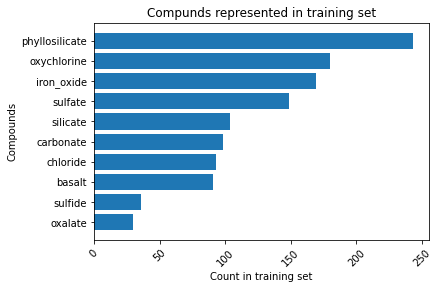

In [7]:
sumlabs = train_labels.aggregate('sum').sort_values()
plt.barh(sumlabs.index, sumlabs, align='center')
plt.ylabel('Compounds')
plt.xticks(rotation=45)
plt.xlabel('Count in training set')
plt.title('Compunds represented in training set')

In [8]:
# Select sample IDs for five commercial samples and five testbed samples
sample_id_commercial = (
    metadata[metadata['instrument_type'] == 'commercial']
    .index
    .values[0: 5]
)

sample_id_testbed = (
    metadata[metadata['instrument_type'] == 'sam_testbed']
    .index
    .values[0: 5]
)

In [9]:
# Import sample files for EDA
sample_commercial_dict = {}
sample_testbed_dict = {}

for i in range(0, 5):
    comm_lab = sample_id_commercial[i]
    sample_commercial_dict[comm_lab] = pd.read_csv(DATA_PATH / train_files[comm_lab])
    
    test_lab = sample_id_testbed[i]
    sample_testbed_dict[test_lab] = pd.read_csv(DATA_PATH / train_files[test_lab])

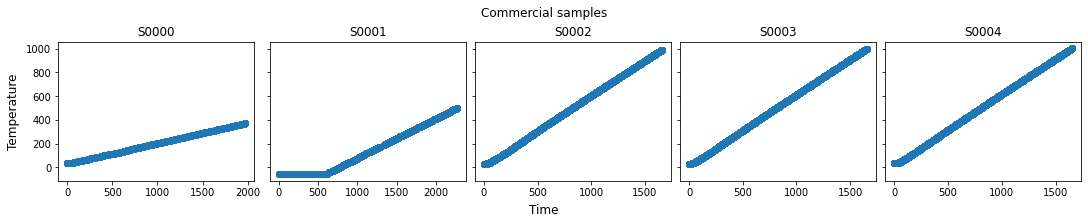

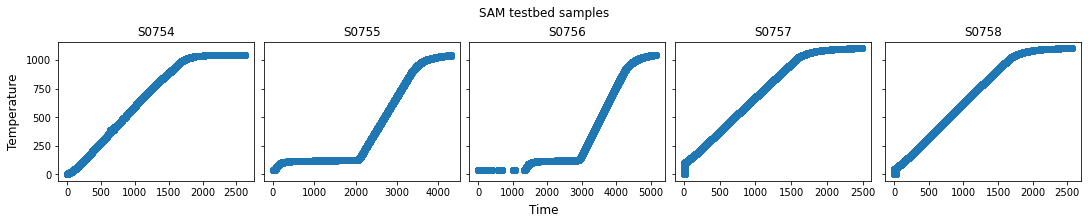

In [10]:
# Plot time vs. temperature for both samples types
def time_vs_temperature(title, sample_id, sample_dict):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True, sharey='all')
    fig.supylabel('Temperature')
    fig.supxlabel('Time')
    fig.suptitle(title)

    for i in range(0, 5):
        sample_lab = sample_id[i]
        plt.subplot(1, 5, i + 1)
        plt.scatter(
            sample_dict[sample_lab]['time'],
            sample_dict[sample_lab]['temp']
        )
        plt.title(sample_lab)

# For commercial
time_vs_temperature('Commercial samples', sample_id_commercial, sample_commercial_dict)

# For SAM testbed
time_vs_temperature('SAM testbed samples', sample_id_testbed, sample_testbed_dict)

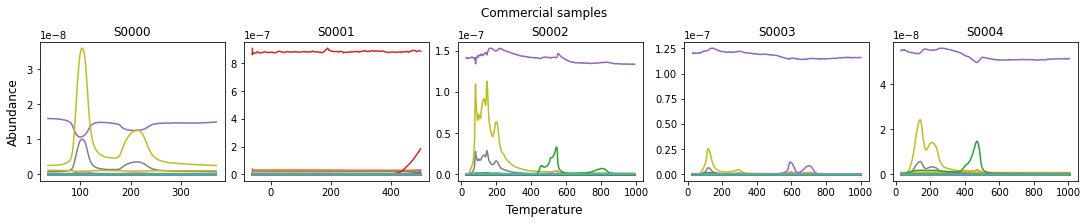

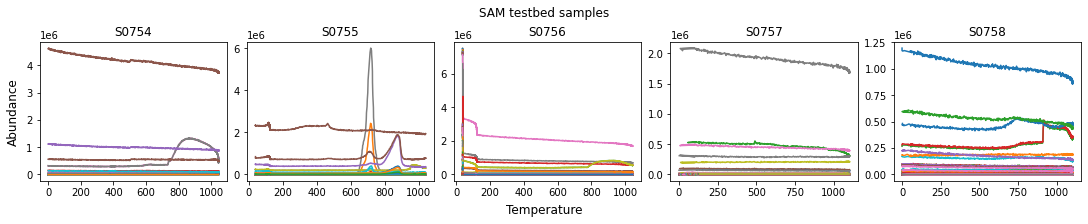

In [11]:
def temperature_vs_abundance(title, sample_id, sample_dict):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True)
    fig.suptitle(title)
    fig.supxlabel('Temperature')
    fig.supylabel('Abundance')
    
    for i in range(0, 5):
        sample_lab = sample_id[i]
        sample_df = sample_dict[sample_lab]
        plt.subplot(1, 5, i + 1)
        
        for m in sample_df['m/z'].unique():
            plt.plot(
                sample_df[sample_df['m/z'] == m]['temp'],
                sample_df[sample_df['m/z'] == m]['abundance']
            )
            
        plt.title(sample_lab)

# For commercial
temperature_vs_abundance('Commercial samples', sample_id_commercial, sample_commercial_dict)

# For commercial
temperature_vs_abundance('SAM testbed samples', sample_id_testbed, sample_testbed_dict)

# Preprocessing

## 1. Standardizing which m/z values to include

In [12]:
# Selecting a testbed sample to demonstrate preprocessing steps
sample_lab = sample_id_testbed[1]
sample_df = sample_testbed_dict[sample_lab]

In [13]:
def drop_frac_and_He(df):
    '''
    Drops fractional m/z values, m/z values > 100, and carrier gas m/z
    
    Args:
        df: a dataframe representing a single sample, containing m/z values
        
    Returns:
        The dataframe without fractional an carrier gas m/z
    '''
    
    # drop fractional m/z values
    df = df[df['m/z'].transform(round) == df['m/z']]
    assert df['m/z'].apply(float.is_integer).all(), 'not all m/z are integers'
    
    # drop m/z values greater than 99
    df = df[df['m/z'] < 100]
    
    # drop carrier gas
    df = df[df['m/z'] != 4]
    
    return df

Text(0.5, 1.0, 'After dropping selected m/z values')

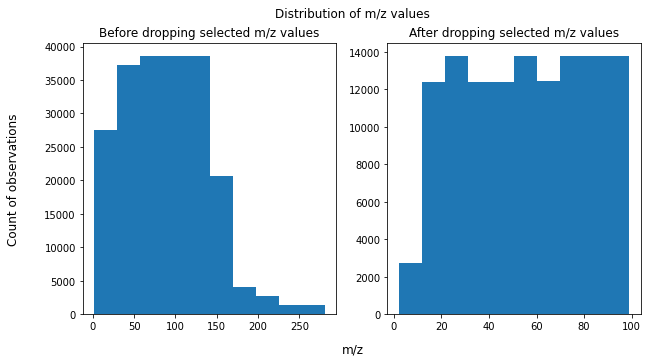

In [14]:
# m/z values before limiting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Distribution of m/z values')
fig.supxlabel('m/z')
fig.supylabel('Count of observations')

plt.subplot(1, 2, 1)
plt.hist(sample_df['m/z'])
plt.title('Before dropping selected m/z values')

# m/z values after limiting
sample_df = drop_frac_and_He(sample_df)
plt.subplot(1, 2, 2)
plt.hist(sample_df['m/z'])
plt.title('After dropping selected m/z values')

## 2. Removing background ion presences

In [15]:
def remove_background_abundance(df):
    '''
    Subtracts minimum abundance value
    
    Args:
        df: dataframe with 'm/z' and 'abundance' columns

    Returns:
        dataframe with minimum abundance subtracted for all observations
    '''

    df["abundance_minsub"] = df.groupby(["m/z"])["abundance"].transform(
        lambda x: (x - x.min())
    )

    return df

Text(0.5, 1.0, 'After subtracting minimum abundance')

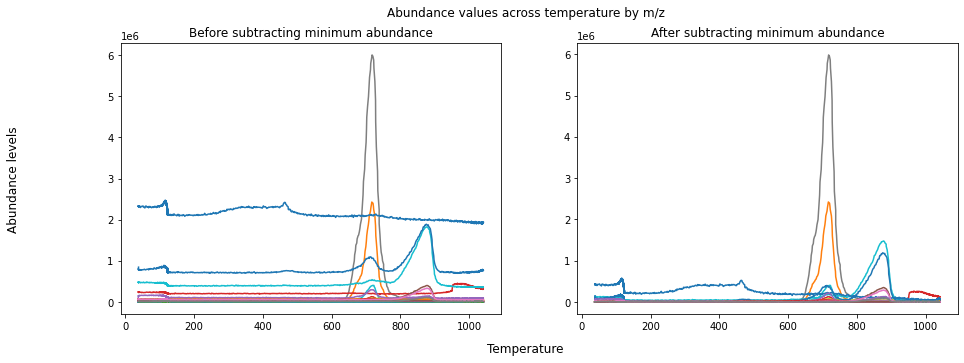

In [16]:
# Abundance values before subtracking minimum
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Abundance values across temperature by m/z')
fig.supxlabel('Temperature')
fig.supylabel('Abundance levels')

plt.subplot(1, 2, 1)

for m in sample_df['m/z'].unique():
    plt.plot(
        sample_df[sample_df['m/z'] == m]['temp'],
        sample_df[sample_df['m/z'] == m]['abundance']
    )

plt.title('Before subtracting minimum abundance')

# After subtracking minimum abundance value
sample_df = remove_background_abundance(sample_df)

plt.subplot(1, 2, 2)

for m in sample_df['m/z'].unique():
    plt.plot(
        sample_df[sample_df['m/z'] == m]['temp'],
        sample_df[sample_df['m/z'] == m]['abundance_minsub']
    )

plt.title('After subtracting minimum abundance')

## 3. Apply logarithm operation

In [17]:
def apply_logarithm(df):
    '''
    Apply the decimal logarithm operation
    
    Args:
        df: dataframe containing abundances and m/z

    Returns:
        dataframe with abundance logarithm values
    '''

    df["abundance_minsub"] = np.log10(df["abundance_minsub"] + 1e-9)
    df = df.replace(np.inf, 0)
    df = df.replace(-np.inf, 0)
    
    df["abundance_minsub"] = df["abundance_minsub"].rolling(window=3).mean()

    return df

Text(0.5, 1.0, 'After applying logarithm')

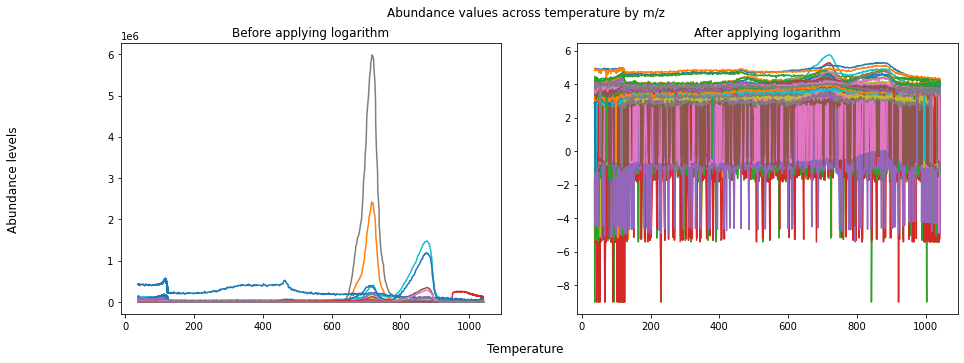

In [18]:
# Abundance values before applying logarithm
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Abundance values across temperature by m/z')
fig.supxlabel('Temperature')
fig.supylabel('Abundance levels')

plt.subplot(1, 2, 1)

for m in sample_df['m/z'].unique():
    plt.plot(
        sample_df[sample_df['m/z'] == m]['temp'],
        sample_df[sample_df['m/z'] == m]['abundance_minsub']
    )

plt.title('Before applying logarithm')

# After subtracking applying logarithm
sample_df = apply_logarithm(sample_df)

plt.subplot(1, 2, 2)

for m in sample_df['m/z'].unique():
    plt.plot(
        sample_df[sample_df['m/z'] == m]['temp'],
        sample_df[sample_df['m/z'] == m]['abundance_minsub']
    )

plt.title('After applying logarithm')

## 4. Convert abundances to relative abundances

In [19]:
def scale_abun(df):
    '''
    Scale abundance from 0-100 according to the min and max values across entire sample

    Args:
        df: dataframe containing abundances and m/z

    Returns:
        dataframe with additional column of scaled abundances
    '''
    
    df['abun_minsub_scaled'] = minmax_scale(df['abundance_minsub'].astype(float))
    return df

## Putting it all together

In [20]:
def preprocess_sample(df):
    df = drop_frac_and_He(df)
    df = remove_background_abundance(df)
    df = apply_logarithm(df)
    df = scale_abun(df)
    return df

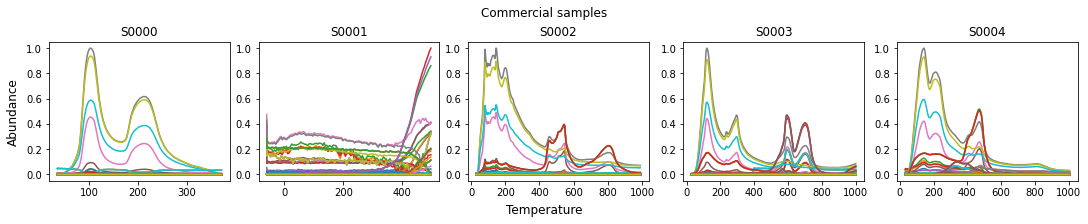

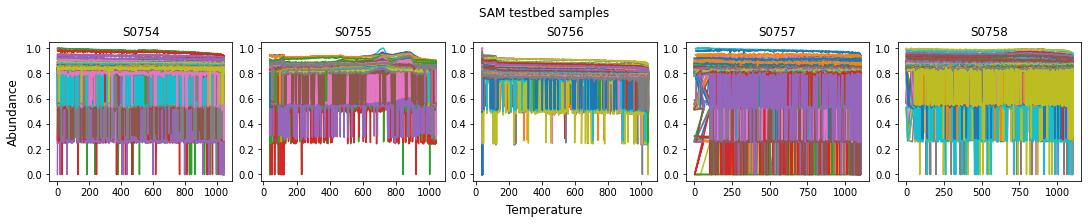

In [21]:
def temperature_vs_abundance_preprocessed(title, sample_id, sample_dict):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True)
    fig.suptitle(title)
    fig.supxlabel('Temperature')
    fig.supylabel('Abundance')
    
    for i in range(0, 5):
        sample_lab = sample_id[i]
        sample_df = sample_dict[sample_lab]
        sample_df = preprocess_sample(sample_df)
        
        plt.subplot(1, 5, i + 1)
        
        for m in sample_df['m/z'].unique():
            plt.plot(
                sample_df[sample_df['m/z'] == m]['temp'],
                sample_df[sample_df['m/z'] == m]['abun_minsub_scaled']
            )
            
        plt.title(sample_lab)

# For commercial
temperature_vs_abundance_preprocessed('Commercial samples', sample_id_commercial, sample_commercial_dict)

# For testbed
temperature_vs_abundance_preprocessed('SAM testbed samples', sample_id_testbed, sample_testbed_dict)

# Feature Engineering

In [22]:
# Create a series of temperature bins
temprange = pd.interval_range(start=-100, end=1500, freq=5)
temp_num = len(temprange)
temprange

IntervalIndex([(-100, -95], (-95, -90], (-90, -85], (-85, -80], (-80, -75] ... (1475, 1480], (1480, 1485], (1485, 1490], (1490, 1495], (1495, 1500]], dtype='interval[int64, right]', length=320)

In [23]:
# Make dataframe with rows that are combinations of all temperature bins
# and all m/z values
m_z_vals = range(0, 100)
m_z_num = len(m_z_vals)
allcombs = list(itertools.product(temprange, [*m_z_vals]))

allcombs_df = pd.DataFrame(allcombs, columns=['temp_bin', 'm/z'])
allcombs_df.head()

,temp_bin,m/z
0,"(-100, -95]",0
1,"(-100, -95]",1
2,"(-100, -95]",2
3,"(-100, -95]",3
4,"(-100, -95]",4


In [24]:
print(f'temperature num: {temp_num}')
print(f'm_z num: {m_z_num}')

temperature num: 320
m_z num: 100


In [25]:
def abun_per_tempbin(df):
    '''
    Transforms dataset to take the preprocessed max abundance for each
    temperature range for each m/z value

    Args:
        df: dataframe to transform

    Returns:
        transformed dataframe
    '''
    
    # Bin temperatures
    df['temp_bin'] = pd.cut(df['temp'], bins=temprange)
    
    # Combine with a list of all temp bin-m/z value combinations
    df = pd.merge(allcombs_df, df, on=['temp_bin', 'm/z'], how='left')
    
    # Aggregate to temperature bin level to find max
    df = df.groupby(['temp_bin', 'm/z']).max('abun_minsub_scaled').reset_index()
    
    # Fill in 0 for abundance values without information
    df = df.replace(np.nan, 0)
    
    # Reshape so each row is a single sample
    df = df.pivot_table(columns=['m/z', 'temp_bin'], values=['abun_minsub_scaled'])
    return df

In [26]:
# Assembling preprocessed and transformed training set

train_features_dict = {}
print(f'Total number of train files: {len(train_files)}')

for i, (sample_id, filepath) in enumerate(tqdm(train_files.items(), position=0, leave=True)):
    # Load training sample
    temp = pd.read_csv(DATA_PATH / filepath)
    
    # Preprocessing training sample
    train_sample_pp = preprocess_sample(temp)
    
    # Feature engineering
    train_sample_fe = abun_per_tempbin(train_sample_pp).reset_index(drop=True)
    train_features_dict[sample_id] = train_sample_fe

train_features = pd.concat(train_features_dict, names=['sample_id', 'dummy_index']).reset_index(level='dummy_index', drop=True)

  0%|                                                                                                                                                                              | 0/766 [00:00<?, ?it/s]

Total number of train files: 766


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 766/766 [04:17<00:00,  2.97it/s]


In [27]:
train_features.head()

m/z                0                                                          \
temp_bin  (-100, -95] (-95, -90] (-90, -85] (-85, -80] (-80, -75] (-75, -70]   
sample_id                                                                      
S0000             0.0        0.0        0.0        0.0        0.0        0.0   
S0001             0.0        0.0        0.0        0.0        0.0        0.0   
S0002             0.0        0.0        0.0        0.0        0.0        0.0   
S0003             0.0        0.0        0.0        0.0        0.0        0.0   
S0004             0.0        0.0        0.0        0.0        0.0        0.0   

m/z                                                    ...           99  \
temp_bin  (-70, -65] (-65, -60] (-60, -55] (-55, -50]  ... (1450, 1455]   
sample_id                                              ...                
S0000            0.0        0.0        0.0        0.0  ...          0.0   
S0001            0.0        0.0        0.0        0.0  ...          0.0   
S0002            0.0        0.0        0.0        0.0  ...          0.0   
S0003            0.0        0.0        0.0        0.0  ...          0.0   
S0004            0.0        0.0        0.0        0.0  ...          0.0   

m/z                                                                         \
temp_bin  (1455, 1460] (1460, 1465] (1465, 1470] (1470, 1475] (1475, 1480]   
sample_id                                                                    
S0000              0.0          0.0          0.0          0.0          0.0   
S0001              0.0          0.0          0.0          0.0          0.0   
S0002              0.0          0.0          0.0          0.0          0.0   
S0003              0.0          0.0          0.0          0.0          0.0   
S0004              0.0          0.0          0.0          0.0          0.0   

m/z                                                            
temp_bin  (1480, 1485] (1485, 1490] (1490, 1495] (1495, 1500]  
sample_id                                                      
S0000              0.0          0.0          0.0          0.0  
S0001              0.0          0.0          0.0          0.0  
S0002              0.0          0.0          0.0          0.0  
S0003              0.0          0.0          0.0          0.0  
S0004              0.0          0.0          0.0          0.0  

[5 rows x 32000 columns]

In [28]:
val_labels = pd.read_csv(DATA_PATH / 'val_labels.csv', index_col='sample_id')
val_labels.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0,0,0,0,0,0,0,0,0,0
S0767,0,0,0,0,0,0,0,0,0,0
S0768,1,0,0,0,0,0,1,1,0,0
S0769,0,0,0,0,0,1,0,0,1,0
S0770,0,0,0,1,0,1,1,0,0,0


In [29]:
val_features_dict = {}
print(f'Total number of validation files: {len(val_files)}')

for i, (sample_id, filepath) in enumerate(tqdm(val_files.items(), position=0, leave=True)):
    # Load sample
    temp = pd.read_csv(DATA_PATH / filepath)
    
    # Preprocessing sample
    val_sample_pp = preprocess_sample(temp)
    
    # Feature engineering
    validation_sample_fe = abun_per_tempbin(val_sample_pp).reset_index(drop=True)
    val_features_dict[sample_id] = validation_sample_fe

  0%|                                                                                                                                                                              | 0/293 [00:00<?, ?it/s]

Total number of validation files: 293


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 293/293 [01:37<00:00,  3.00it/s]


In [30]:
val_features = pd.concat(val_features_dict, names=['sample_id', 'dummy_index']).reset_index(level='dummy_index', drop=True)

# Combine both train and validation features
train_features = pd.concat([train_features, val_features])
train_labels = pd.concat([train_labels, val_labels])

In [31]:
train_features.head()

m/z                0                                                          \
temp_bin  (-100, -95] (-95, -90] (-90, -85] (-85, -80] (-80, -75] (-75, -70]   
sample_id                                                                      
S0000             0.0        0.0        0.0        0.0        0.0        0.0   
S0001             0.0        0.0        0.0        0.0        0.0        0.0   
S0002             0.0        0.0        0.0        0.0        0.0        0.0   
S0003             0.0        0.0        0.0        0.0        0.0        0.0   
S0004             0.0        0.0        0.0        0.0        0.0        0.0   

m/z                                                    ...           99  \
temp_bin  (-70, -65] (-65, -60] (-60, -55] (-55, -50]  ... (1450, 1455]   
sample_id                                              ...                
S0000            0.0        0.0        0.0        0.0  ...          0.0   
S0001            0.0        0.0        0.0        0.0  ...          0.0   
S0002            0.0        0.0        0.0        0.0  ...          0.0   
S0003            0.0        0.0        0.0        0.0  ...          0.0   
S0004            0.0        0.0        0.0        0.0  ...          0.0   

m/z                                                                         \
temp_bin  (1455, 1460] (1460, 1465] (1465, 1470] (1470, 1475] (1475, 1480]   
sample_id                                                                    
S0000              0.0          0.0          0.0          0.0          0.0   
S0001              0.0          0.0          0.0          0.0          0.0   
S0002              0.0          0.0          0.0          0.0          0.0   
S0003              0.0          0.0          0.0          0.0          0.0   
S0004              0.0          0.0          0.0          0.0          0.0   

m/z                                                            
temp_bin  (1480, 1485] (1485, 1490] (1490, 1495] (1495, 1500]  
sample_id                                                      
S0000              0.0          0.0          0.0          0.0  
S0001              0.0          0.0          0.0          0.0  
S0002              0.0          0.0          0.0          0.0  
S0003              0.0          0.0          0.0          0.0  
S0004              0.0          0.0          0.0          0.0  

[5 rows x 32000 columns]

In [32]:
# Make sure that all sample IDs in features and labels are identical
assert train_features.index.equals(train_labels.index)

# Perform Modeling

In [33]:
from sklearn.model_selection import KFold

# Define k-fold validation
skf = KFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
train_val_indices = list(skf.split(train_features, train_labels))
len(train_val_indices)

10

In [34]:
train_index, val_index = train_val_indices[0]
len(train_index), len(val_index)

(953, 106)

In [35]:
def to_2d(data):
    length = data.shape[0]
    data = np.reshape(data, (length, m_z_num, temp_num))
    data = np.swapaxes(data, 1, 2)
    return data

def get_features_with_labels(indices):
    X = to_2d(train_features.values[indices])
    y = train_labels.values[indices]
    return X, y

X_train, y_train = get_features_with_labels(train_index)
X_val, y_val = get_features_with_labels(val_index)

input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

print(f'{X_train.shape} {y_train.shape}')
print(f'{X_val.shape} {y_val.shape}')

print(f'\n{input_shape} {num_classes}')

(953, 320, 100) (953, 10)
(106, 320, 100) (106, 10)

(320, 100) 10


2022-04-18 13:41:42.858299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 13:41:42.858681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 13:41:42.858978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 13:41:42.859470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 13:41:42.859773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

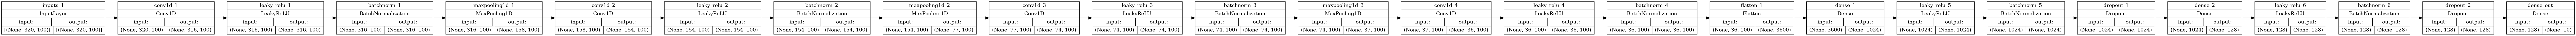

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.utils import plot_model

def get_model():
    model = keras.Sequential([
        keras.Input(shape=input_shape, name='inputs_1'),

        L.Conv1D(100, 5, name='conv1d_1'),
        L.LeakyReLU(alpha=0.05, name='leaky_relu_1'),
        L.BatchNormalization(name='batchnorm_1'),
        L.MaxPooling1D(2, name='maxpooling1d_1'),

        L.Conv1D(100, 5, name='conv1d_2'),
        L.LeakyReLU(alpha=0.05, name='leaky_relu_2'),
        L.BatchNormalization(name='batchnorm_2'),
        L.MaxPooling1D(2, name='maxpooling1d_2'),

        L.Conv1D(100, 4, name='conv1d_3'),
        L.LeakyReLU(alpha=0.05, name='leaky_relu_3'),
        L.BatchNormalization(name='batchnorm_3'),
        L.MaxPooling1D(2, name='maxpooling1d_3'),

        L.Conv1D(100, 2, name='conv1d_4'),
        L.LeakyReLU(alpha=0.05, name='leaky_relu_4'),
        L.BatchNormalization(name='batchnorm_4'),
        L.Flatten(name='flatten_1'),

        L.Dense(1024, name='dense_1'),
        L.LeakyReLU(alpha=0.05, name='leaky_relu_5'),
        L.BatchNormalization(name='batchnorm_5'),
        L.Dropout(0.5, name='dropout_1'),

        L.Dense(128, name='dense_2'),
        L.LeakyReLU(alpha=0.05, name='leaky_relu_6'),
        L.BatchNormalization(name='batchnorm_6'),
        L.Dropout(0.5, name='dropout_2'),

        L.Dense(num_classes, activation='sigmoid', name='dense_out')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

model = get_model()
plot_model(model, rankdir='LR', show_shapes=True)

In [37]:
from tqdm.keras import TqdmCallback
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=16,
    mode='auto',
    restore_best_weights=True,
    verbose=1
)

models = []
logs = []

for i, (train_index, val_index) in enumerate(train_val_indices):
    print(f'Model {i}:')
    X_train, y_train = get_features_with_labels(train_index)
    X_val, y_val = get_features_with_labels(val_index)
    
    model = get_model()
    history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val),
                        callbacks=[early_stopping, TqdmCallback(verbose=1)], verbose=0)
    
    models.append(model)
    logs.append(history.history)
    
    best_val_loss = min(logs[-1]['val_loss'])
    print(f'Best val loss: {best_val_loss:.4f}')
    
    if i < len(train_val_indices) - 1:
        print()

Model 0:


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-04-18 13:41:44.538622: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 121984000 exceeds 10% of free system memory.
2022-04-18 13:41:44.759754: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 121984000 exceeds 10% of free system memory.
2022-04-18 13:41:50.930991: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


Restoring model weights from the end of the best epoch: 55.
Epoch 00071: early stopping
Best val loss: 0.1567

Model 1:


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-04-18 13:42:43.634369: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 121984000 exceeds 10% of free system memory.
2022-04-18 13:42:43.747758: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 121984000 exceeds 10% of free system memory.


Restoring model weights from the end of the best epoch: 35.
Epoch 00051: early stopping
Best val loss: 0.1389

Model 2:


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-04-18 13:43:14.352501: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 121984000 exceeds 10% of free system memory.


Restoring model weights from the end of the best epoch: 26.
Epoch 00042: early stopping
Best val loss: 0.1026

Model 3:


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 41.
Epoch 00057: early stopping
Best val loss: 0.1411

Model 4:


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 38.
Epoch 00054: early stopping
Best val loss: 0.1090

Model 5:


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 43.
Epoch 00059: early stopping
Best val loss: 0.0952

Model 6:


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 34.
Epoch 00050: early stopping
Best val loss: 0.1268

Model 7:


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 41.
Epoch 00057: early stopping
Best val loss: 0.0792

Model 8:


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 29.
Epoch 00045: early stopping
Best val loss: 0.1487

Model 9:


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 29.
Epoch 00045: early stopping
Best val loss: 0.1185


Best val loss: 0.1567


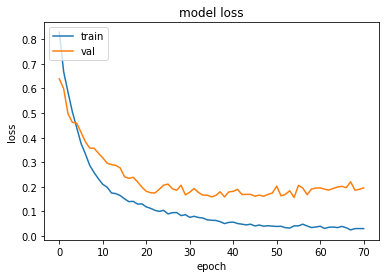

In [38]:
init_log = logs[0]
best_val_loss = min(init_log['val_loss'])
print(f'Best val loss: {best_val_loss:.4f}')

plt.plot(init_log['loss'])
plt.plot(init_log['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

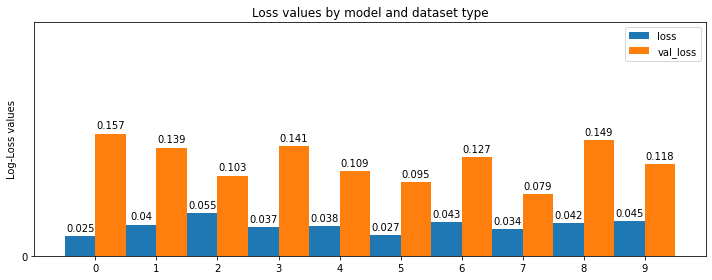

In [39]:
labels = [i for i in range(len(models))]
loss_values = [int(round(min(log['loss']) * 1000)) / 1000 for log in logs]
val_loss_values = [int(round(min(log['val_loss']) * 1000)) / 1000 for log in logs]

x = np.arange(len(labels))
width = 0.5

fig, ax = plt.subplots(figsize=(10, 4))
rects1 = ax.bar(x - width / 2, loss_values, width, label='loss')
rects2 = ax.bar(x + width / 2, val_loss_values, width, label='val_loss')

ax.set_ylabel('Log-Loss values')
ax.set_title('Loss values by model and dataset type')

ax.set_xticks(x)
ax.set_yticks(labels)
ax.set_ylim([0, 0.3])
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

In [49]:
# Evaluate Submission
val_loss = np.mean([min(log['val_loss']) for log in logs])
print(f'Val loss: {val_loss:.4f}')

Val loss: 0.1217


# Preparing Submission

In [40]:
# Create dict with both validation and test sample IDs and paths
all_test_files = val_files.copy()
all_test_files.update(test_files)
print(f'Total test files: {len(all_test_files)}')

Total test files: 804


In [41]:
# Import submission format
submission_template_df = pd.read_csv(
    DATA_PATH / 'submission_format.csv', index_col='sample_id'
)

compounds_order = submission_template_df.columns
sample_order = submission_template_df.index

In [42]:
def read_sample(sample_id):
    # Import sample
    temp_sample = pd.read_csv(DATA_PATH / all_test_files[sample_id])
    
    # Preprocess sample
    temp_sample = preprocess_sample(temp_sample)
    
    # Feature engineering on sample
    temp_sample = abun_per_tempbin(temp_sample)
    return temp_sample

np_samples = []

for sample_id in tqdm(sample_order, position=0, leave=True):
    if sample_id not in val_features_dict.keys():
        temp_sample = read_sample(sample_id)
    else:
        temp_sample = val_features_dict[sample_id]
    
    # Convert to 2D
    np_sample = temp_sample.to_numpy()
    np_sample = to_2d(np_sample)
    np_samples.append(np_sample)

len(np_samples)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 804/804 [03:00<00:00,  4.46it/s]


804

In [43]:
# Generate predictions for all classes
preds = []

for model in models:
    results = []
    
    with tqdm(total=len(np_samples), position=0, leave=True) as tqdm_bar:
        for np_sample in np_samples:
            row_result = model.predict(np_sample)[0]
            results.append(row_result)
            tqdm_bar.update(1)
        
    preds.append(results)

preds = np.mean(preds, axis=0)
preds.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 804/804 [00:29<00:00, 27.21it/s]


(804, 10)

In [44]:
# Dataframe to store submissions in
final_submission_df = pd.DataFrame(preds,
    index = sample_order,
    columns = compounds_order
)

final_submission_df.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.004332,0.003763,0.008565,0.003266,0.001609,0.002051,0.001370,0.092047,0.018822,0.002606
S0767,0.027047,0.010083,0.003517,0.030393,0.002747,0.016228,0.026657,0.366652,0.019854,0.006516
S0768,0.933020,0.456142,0.009322,0.195749,0.006520,0.018973,0.387429,0.913412,0.282467,0.006995
S0769,0.041625,0.009298,0.060407,0.014621,0.002339,0.957553,0.012942,0.017278,0.904180,0.004780
S0770,0.001055,0.001862,0.002191,0.781006,0.000514,0.995073,0.993210,0.001391,0.000514,0.000975


In [45]:
# Check that columns and rows are the same between final submission and submission format
assert final_submission_df.index.equals(submission_template_df.index)
assert final_submission_df.columns.equals(submission_template_df.columns)

In [46]:
final_submission_df.to_csv('results/submission.csv')